In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset Path
data_path = 'mnist_test_seq.npy'

# Load Data as Numpy Array
MovingMNIST = np.load(data_path).transpose(1, 0, 2, 3)  # Shape: (10000, 20, 64, 64)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Split into Train, Validation, and Test
train_data = MovingMNIST[:8000]   # 8000 samples for training
val_data = MovingMNIST[8000:9000] # 1000 samples for validation
test_data = MovingMNIST[9000:]    # 1000 samples for testing

# Define custom Dataset that returns (frame_t, frame_t+1) pairs
class FramePairDataset(Dataset):
    def __init__(self, sequences):
        self.pairs = []
        for seq in sequences:
            for i in range(19):  # Create 19 pairs per sequence
                input_frame = seq[i]
                target_frame = seq[i + 1]
                self.pairs.append((input_frame, target_frame))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x, y = self.pairs[idx]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize and add channel dim
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0) / 255.0
        return x, y  # Shapes: (1, 64, 64)

# Batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(FramePairDataset(train_data), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(FramePairDataset(val_data), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(FramePairDataset(test_data), batch_size=batch_size, shuffle=False)

# Check shapes
sample_X, sample_Y = next(iter(train_loader))
print(f"Input shape (X): {sample_X.shape}")  # Expected: (batch_size, 1, 64, 64)
print(f"Target shape (Y): {sample_Y.shape}")  # Expected: (batch_size, 1, 64, 64)


c:\Users\ASUS\anaconda3\envs\deeplearning\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Input shape (X): torch.Size([16, 1, 64, 64])
Target shape (Y): torch.Size([16, 1, 64, 64])


In [8]:
import torch
import torch.nn as nn

# Define a U-Net block
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super(UNetBlock, self).__init__()
        if down:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5) if use_dropout else None

    def forward(self, x):
        x = self.conv(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

# Define U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=9, out_channels=1, features=[64, 128, 256, 512]):
        super(UNetGenerator, self).__init__()
        # Encoder (Downsampling)
        self.enc1 = UNetBlock(in_channels, features[0], down=True, use_dropout=False)   # 64x64 -> 32x32
        self.enc2 = UNetBlock(features[0], features[1], down=True, use_dropout=False)   # 32x32 -> 16x16
        self.enc3 = UNetBlock(features[1], features[2], down=True, use_dropout=False)   # 16x16 -> 8x8
        self.enc4 = UNetBlock(features[2], features[3], down=True, use_dropout=False)   # 8x8 -> 4x4
        self.enc5 = UNetBlock(features[3], features[3], down=True, use_dropout=False)   # 4x4 -> 2x2

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[3], features[3], kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )  # 2x2 -> 1x1

        # Decoder (Upsampling)
        self.dec5 = UNetBlock(features[3], features[3], down=False, use_dropout=True)   # 1x1 -> 2x2
        self.dec4 = UNetBlock(features[3] * 2, features[3], down=False, use_dropout=False)  # 2x2 -> 4x4
        self.dec3 = UNetBlock(features[3] * 2, features[2], down=False, use_dropout=False)  # 4x4 -> 8x8
        self.dec2 = UNetBlock(features[2] * 2, features[1], down=False, use_dropout=False)  # 8x8 -> 16x16
        self.dec1 = UNetBlock(features[1] * 2, features[0], down=False, use_dropout=False)  # 16x16 -> 32x32


        self.final = nn.Sequential(
            nn.ConvTranspose2d(features[0]* 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Outputs in range [-1, 1]
        )  # 32x32 -> 64x64

    def forward(self, x):
        # Downsampling
        d1 = self.enc1(x)
        d2 = self.enc2(d1)
        d3 = self.enc3(d2)
        d4 = self.enc4(d3)
        d5 = self.enc5(d4)

        # Bottleneck
        b = self.bottleneck(d5)

        # Upsampling with skip connections (Concatenation)
        u5 = self.dec5(b)
        u5 = torch.cat([u5, d5], dim=1)

        u4 = self.dec4(u5)
        u4 = torch.cat([u4, d4], dim=1)

        u3 = self.dec3(u4)
        u3 = torch.cat([u3, d3], dim=1)

        u2 = self.dec2(u3)
        u2 = torch.cat([u2, d2], dim=1)

        u1 = self.dec1(u2)
        u1 = torch.cat([u1, d1], dim=1)

        return self.final(u1)

# Initialize Generator
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = UNetGenerator(in_channels=1).to(device)


# Test generator output shape
x = torch.randn((8, 1, 64, 64)).to(device)

y_pred = generator(x)
print(f"Generator output shape: {y_pred.shape}")  # Expected: (8, 1, 64, 64)


Generator output shape: torch.Size([8, 1, 64, 64])


In [9]:
import torch
import torch.nn as nn

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=2, features=[64, 128, 256, 512]):
        super(PatchGANDiscriminator, self).__init__()

        def conv_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, bias=False),  #64×64 → 32×32
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(features[0], features[1], stride=2),
            conv_block(features[1], features[2], stride=2),
            conv_block(features[2], features[3], stride=1),

            nn.Conv2d(features[3], 1, kernel_size=4, stride=1, padding=1)  
        )

    def forward(self, x):
        return self.model(x) 


# Initialize Discriminator
device = 'cuda' if torch.cuda.is_available() else 'cpu'
discriminator = PatchGANDiscriminator().to(device)

# Test discriminator output shape
x = torch.randn((8, 2, 64, 64)).to(device) 
y_pred = discriminator(x)
print(f"Discriminator output shape: {y_pred.shape}")  # Expected: (8, 1, 6, 6)


Discriminator output shape: torch.Size([8, 1, 6, 6])


In [10]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

class MovingMNISTDataset(Dataset):
    def __init__(self, npy_file):
        self.data = np.load(npy_file)  # Shape: (20, 10000, 64, 64)
        self.data = self.data.transpose(1, 0, 2, 3)  # New Shape: (10000, 20, 64, 64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx] / 255.0  # Normalize to [0, 1]

        input_frame = sequence[0]    # Frame at time t
        target_frame = sequence[1]   # Frame at time t+1

        # Add channel dimension: (64, 64) -> (1, 64, 64)
        input_frame = torch.tensor(input_frame, dtype=torch.float32).unsqueeze(0)
        target_frame = torch.tensor(target_frame, dtype=torch.float32).unsqueeze(0)

        return input_frame, target_frame

# Load Dataset
dataset = MovingMNISTDataset("mnist_test_seq.npy")

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [23]:
import torch.optim as optim
from tqdm import tqdm

# Initialize Generator and Discriminator
generator = UNetGenerator(in_channels=1).to(device)
discriminator = PatchGANDiscriminator(in_channels=2).to(device)  # 1 input + 1 target = 2 channels

# Optimizers
lr = 2e-4
beta1, beta2 = 0.5, 0.999
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Loss functions
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    lambda_L1 = 10 # Decaying L1 loss weight
    loop = tqdm(dataloader, leave=True)

    for i, (input_frames, real_next_frame) in enumerate(loop):
        input_frames = input_frames.to(device)           # (B, 1, 64, 64)
        real_next_frame = real_next_frame.to(device)     # (B, 1, 64, 64)

        # ===== Forward Pass =====
        fake_next_frame = generator(input_frames)

        # Create real and fake pairs for discriminator
        real_pair = torch.cat((input_frames, real_next_frame), dim=1)  # (B, 2, 64, 64)
        fake_pair = torch.cat((input_frames, fake_next_frame), dim=1)  # (B, 2, 64, 64)

        # ===== Train Discriminator =====
        if (epoch + 1) % 2 == 0:
            for _ in range(2): 
                disc_real = discriminator(real_pair)
                disc_fake = discriminator(fake_pair.detach())

                loss_real = bce_loss(disc_real, torch.full_like(disc_real, 0.9))
                loss_fake = bce_loss(disc_fake, torch.zeros_like(disc_fake))
                disc_loss = (loss_real + loss_fake) / 2

                disc_optimizer.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()
        else:
            disc_loss = torch.tensor(0.0).to(device)

        # ===== Train Generator =====
        disc_fake = discriminator(fake_pair)
        adversarial_loss = bce_loss(disc_fake, torch.ones_like(disc_fake))
        l1_loss_value = l1_loss(fake_next_frame, real_next_frame) * lambda_L1
        gen_loss = adversarial_loss + l1_loss_value

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Logging
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(Gen_Loss=gen_loss.item(), Disc_Loss=disc_loss.item())


Epoch [10/10]: 100%|██████████| 1250/1250 [01:06<00:00, 18.91it/s, Disc_Loss=0.163, Gen_Loss=13.6]


In [24]:
import matplotlib.pyplot as plt
import os

# Function to visualize real and generated frames
def visualize_samples(epoch, input_frames, real_next_frame, fake_next_frame, save_path="generated_samples"):
    os.makedirs(save_path, exist_ok=True)  # Create folder if not exists

    fig, axes = plt.subplots(3, 8, figsize=(15, 5))  # 3 rows: input, real, fake

    for i in range(8):  # Show first 8 samples
        axes[0, i].imshow(input_frames[i, -1].cpu().detach().numpy(), cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(real_next_frame[i, 0].cpu().detach().numpy(), cmap='gray')
        axes[1, i].axis('off')

        axes[2, i].imshow(fake_next_frame[i, 0].cpu().detach().numpy(), cmap='gray')  
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel("Input (t-1)")
    axes[1, 0].set_ylabel("Real (t)")
    axes[2, 0].set_ylabel("Fake (t)")

    plt.savefig(f"{save_path}/epoch_{epoch}.png")
    plt.close()

# Inside training loop, after generator step
if (epoch + 1) % 1 == 0:  # Save every epoch
    visualize_samples(epoch, input_frames, real_next_frame, fake_next_frame)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21652\3628018701.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(buf))


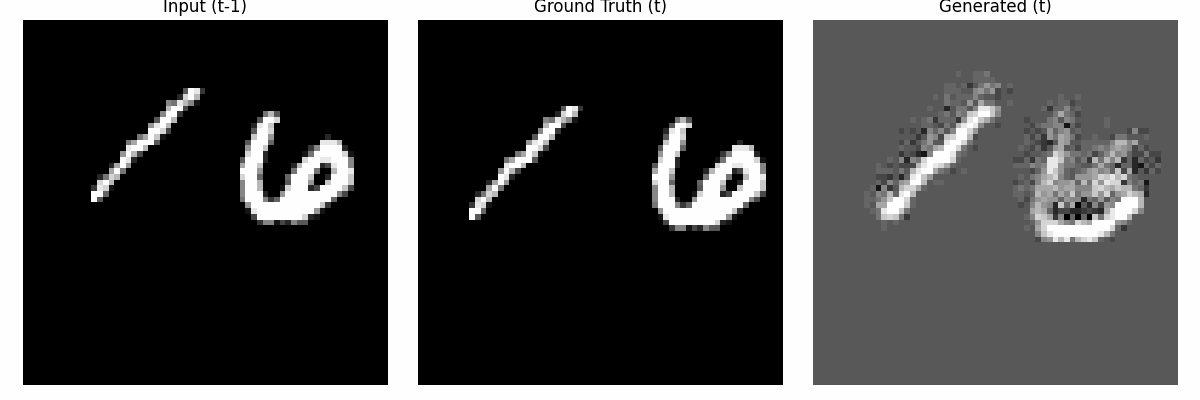

In [25]:
import imageio
import torch
import numpy as np
import io
from IPython.display import display, Image
import matplotlib.pyplot as plt

def create_gif(input_frames, fake_frames, real_frames, save_path="generated_gif.gif"):
    images = []

    for t in range(fake_frames.shape[1]):  # Iterate over timesteps
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_frames[0, -1].cpu().detach().numpy(), cmap='gray')  
        axes[0].set_title("Input (t-1)")
        axes[0].axis('off')

        axes[1].imshow(real_frames[0, t].cpu().detach().numpy(), cmap='gray')  
        axes[1].set_title("Ground Truth (t)")
        axes[1].axis('off')

        axes[2].imshow(fake_frames[0, t].cpu().detach().numpy(), cmap='gray') 
        axes[2].set_title("Generated (t)")
        axes[2].axis('off')

        plt.tight_layout()

        # Save to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        images.append(imageio.imread(buf))
        plt.close()

    # Save GIF
    imageio.mimsave(save_path, images, duration=200)

    # Display GIF in Jupyter Notebook
    display(Image(filename=save_path))

# After training:
create_gif(input_frames, fake_next_frame, real_next_frame)


In [38]:
import imageio
import numpy as np
import io
from IPython.display import display
from ipywidgets import Image as WImage, HBox

# Replace variable names accordingly
input_np = input_frames.cpu().numpy().squeeze(1)
target_np = real_next_frame.cpu().numpy().squeeze(1)
generated_np = fake_next_frame.cpu().detach().numpy().squeeze(1)

# Normalize
def normalize(img):
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return (img * 255).astype(np.uint8)

# Create frames
frames = []
for i in range(len(input_np)):
    inp = normalize(input_np[i])
    tgt = normalize(target_np[i])
    gen = normalize(generated_np[i])

    frame = np.hstack([inp, tgt, gen])
    frames.append(frame)

# Save and display as GIF
with io.BytesIO() as gif_buffer:
    imageio.mimsave(gif_buffer, frames, format='GIF', duration=200)
    output_gif = gif_buffer.getvalue()

    # Save to disk
    with open("pix2pix_prediction.gif", "wb") as f:
        f.write(output_gif)

display(HBox([WImage(value=output_gif)]))
